In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
df = pd.read_csv('rfmdata.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df.head()

,fullVisitorId,date,revenue
0,9624789523147347433,2017-03-24,43.0
1,4560048854801219223,2017-03-24,65.0
2,9826816980924031810,2017-03-24,42.0
3,3126428444962673497,2017-03-24,27.0
4,8017527495949351517,2017-03-24,14.0


### Recency

calculating recency for customers who had made a purchase with a company.

In [3]:
df_recency = df.groupby(by=['fullVisitorId'],as_index=False)['date'].max()
df_recency.columns = ['fullVisitorId', 'date']
recent_date = df_recency['date'].max()
df_recency['Recency'] = df_recency['date'].apply(lambda x: (recent_date - x).days)
df_recency.head()

,fullVisitorId,date,Recency
0,213131142648941,2017-04-28,95
1,435324061339869,2016-10-20,285
2,562678147042735,2017-04-24,99
3,585708896049892,2016-12-21,223
4,670722016498267,2017-07-10,22


### Frecuency

calculating the frequency of frequent transactions of the customer in ordering/buying some product from the company.

In [4]:
frequency_df = df.drop_duplicates().groupby(by=['fullVisitorId'], as_index=False)['date'].count()
frequency_df.columns = ['fullVisitorId', 'Frequency']
frequency_df.head()

,fullVisitorId,Frequency
0,213131142648941,1
1,435324061339869,1
2,562678147042735,1
3,585708896049892,1
4,670722016498267,1


### Monetary Value

calculating the monetary value of customer spend on purchasing products from the company.

In [5]:
monetary_df = df.groupby(by='fullVisitorId', as_index=False)['revenue'].sum()
monetary_df.columns = ['fullVisitorId', 'Monetary']
monetary_df.head()

,fullVisitorId,Monetary
0,213131142648941,40.0
1,435324061339869,47.0
2,562678147042735,158.0
3,585708896049892,46.0
4,670722016498267,44.0


### Merging all three columns in one dataframe

In [6]:
rf_df = df_recency.merge(frequency_df, on='fullVisitorId')
rfm_df = rf_df.merge(monetary_df, on='fullVisitorId').drop(columns='date')
rfm_df.head()

,fullVisitorId,Recency,Frequency,Monetary
0,213131142648941,95,1,40.0
1,435324061339869,285,1,47.0
2,562678147042735,99,1,158.0
3,585708896049892,223,1,46.0
4,670722016498267,22,1,44.0


## 1. Customer Segragation by Ranking

Normalizing the rank of the customers within a company to analyze the ranking

In [7]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head() 

,fullVisitorId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,213131142648941,95,1,40.0,71.204451,45.173069,45.173069
1,435324061339869,285,1,47.0,21.668087,45.173069,45.173069
2,562678147042735,99,1,158.0,69.765927,45.173069,45.173069
3,585708896049892,223,1,46.0,42.584332,45.173069,45.173069
4,670722016498267,22,1,44.0,91.940254,45.173069,45.173069


### Calculating RFM score

we divide our customers. Here we rate them on a scale of 5. Formula used for calculating rfm score is : 
0.15*Recency score + 0.28*Frequency score + 0.57 *Monetary score

In [8]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['fullVisitorId', 'RFM_Score']].head()

,fullVisitorId,RFM_Score
0,213131142648941,2.45
1,435324061339869,2.08
2,562678147042735,2.44
3,585708896049892,2.24
4,670722016498267,2.61


### Rating Customer based upon the RFM score
<br>rfm score >4.5 : Top Customer
<br>4.5 > rfm score > 4 : High Value Customer
<br>4>rfm score >3 : Medium value customer
<br>3>rfm score>1.6 : Low-value customer
<br>rfm score<1.6 :Lost Customer

In [9]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['fullVisitorId', 'RFM_Score', 'Customer_segment']].head(20)

,fullVisitorId,RFM_Score,Customer_segment
0,213131142648941,2.45,Low Value Customers
1,435324061339869,2.08,Low Value Customers
2,562678147042735,2.44,Low Value Customers
3,585708896049892,2.24,Low Value Customers
4,670722016498267,2.61,Low Value Customers
5,852801263780322,2.59,Low Value Customers
6,1123528056036404,2.20,Low Value Customers
7,1905118576359487,2.08,Low Value Customers
8,2527528149176601,2.16,Low Value Customers
9,2709834583138581,2.22,Low Value Customers


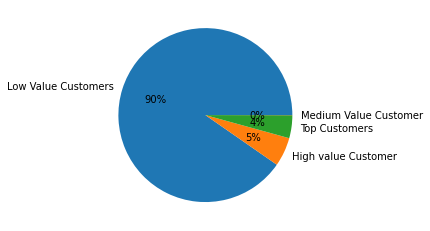

In [10]:

plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

In [11]:
rrfm=rfm_df.groupby(["Customer_segment"])["Recency","Frequency","Monetary"].mean()

C:\Users\saeid\AppData\Local\Temp\ipykernel_28116\3656623852.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rrfm=rfm_df.groupby(["Customer_segment"])["Recency","Frequency","Monetary"].mean()


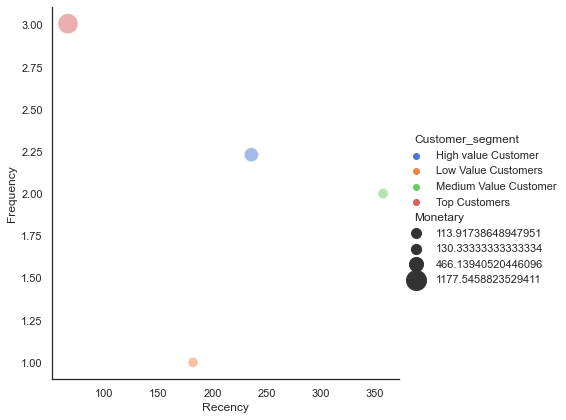

In [12]:
sns.set_theme(style="white")

sns.relplot(x="Recency", y="Frequency",hue="Customer_segment", size="Monetary",
            sizes=(100, 400), alpha=.5, palette="muted",
            height=6, data=rrfm)

Grouped customer based on a self-defined score which is calculated by Recency, Frequency and Monetary Value.

## 2. Customer Segragation by K-Means Clustering

In [13]:
rfm_df.head()

,fullVisitorId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,213131142648941,95,1,40.0,71.20,45.17,45.17,2.45,Low Value Customers
1,435324061339869,285,1,47.0,21.67,45.17,45.17,2.08,Low Value Customers
2,562678147042735,99,1,158.0,69.77,45.17,45.17,2.44,Low Value Customers
3,585708896049892,223,1,46.0,42.58,45.17,45.17,2.24,Low Value Customers
4,670722016498267,22,1,44.0,91.94,45.17,45.17,2.61,Low Value Customers


In [14]:
rfm_df.describe()


,fullVisitorId,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
count,9.996000e+03,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,4.478856e+18,179.993197,1.151861,178.101741,50.107559,50.002310,50.002310,2.500920
std,3.066153e+18,108.295980,0.710352,1437.176174,28.928202,14.790216,14.790216,0.676665
min,2.131311e+14,0.000000,1.000000,1.000000,0.140000,45.170000,45.170000,1.920000
25%,1.577139e+18,84.000000,1.000000,30.000000,25.090000,45.170000,45.170000,2.120000
50%,4.346933e+18,183.000000,1.000000,55.000000,50.010000,45.170000,45.170000,2.330000
75%,7.132082e+18,270.000000,1.000000,117.000000,75.350000,45.170000,45.170000,2.540000
max,9.998996e+18,365.000000,33.000000,128414.000000,100.000000,100.000000,100.000000,5.000000


C:\Users\saeid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


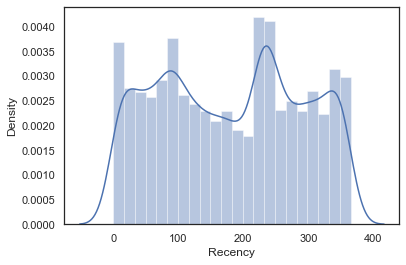

In [15]:
x = rfm_df['Recency']
ax = sns.distplot(x)

C:\Users\saeid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


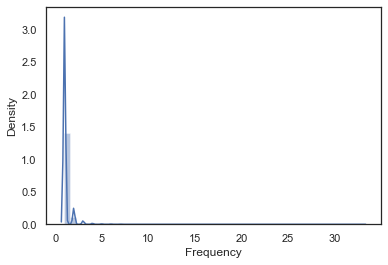

In [16]:
y = rfm_df['Frequency']
ay = sns.distplot(y)

C:\Users\saeid\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


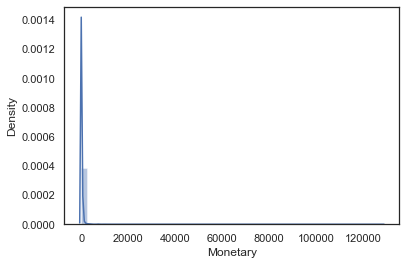

In [17]:
z = rfm_df['Monetary']
az = sns.distplot(z)

{'whiskers': [<matplotlib.lines.Line2D at 0x171f75f2280>,
 'caps': [<matplotlib.lines.Line2D at 0x171f75f2820>,
 'boxes': [<matplotlib.lines.Line2D at 0x171f75f20d0>],
 'medians': [<matplotlib.lines.Line2D at 0x171f75f2dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x171f76000d0>],
 'means': []}

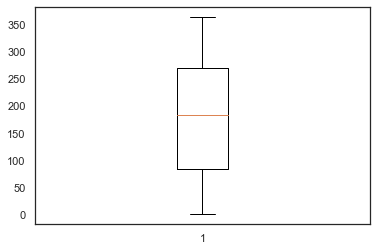

In [18]:
plt.boxplot(rfm_df.Recency)

{'whiskers': [<matplotlib.lines.Line2D at 0x171f555f190>,
 'caps': [<matplotlib.lines.Line2D at 0x171f555fc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x171f555ec70>],
 'medians': [<matplotlib.lines.Line2D at 0x171f5da33d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x171f5da3850>],
 'means': []}

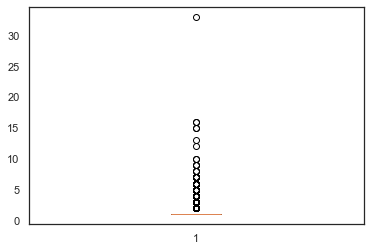

In [19]:
plt.boxplot(rfm_df.Frequency)

In [20]:
rfm_df.Frequency.mean()

1.1518607442977191

In [21]:
rfm_df.Frequency.std()

0.7103519120373583

In [22]:
upper_limit=rfm_df.Frequency.mean()+3*rfm_df.Frequency.std()
upper_limit

3.282916480409794

In [23]:
lower_limit=rfm_df.Frequency.mean()-3*rfm_df.Frequency.std()
lower_limit

-0.9791949918143557

In [24]:
rfm_df=rfm_df[(rfm_df.Frequency<upper_limit)&(rfm_df.Frequency>lower_limit)]

{'whiskers': [<matplotlib.lines.Line2D at 0x171f7641400>,
 'caps': [<matplotlib.lines.Line2D at 0x171f76419a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x171f7641100>],
 'medians': [<matplotlib.lines.Line2D at 0x171f7641f40>],
 'fliers': [<matplotlib.lines.Line2D at 0x171f764c250>],
 'means': []}

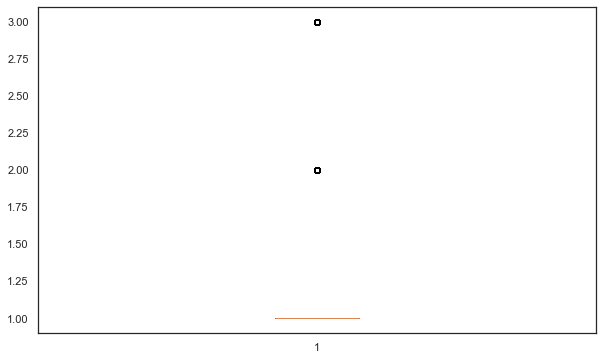

In [25]:
plt.figure(figsize=(10, 6))
plt.boxplot(rfm_df.Frequency)

{'whiskers': [<matplotlib.lines.Line2D at 0x171f76a6250>,
 'caps': [<matplotlib.lines.Line2D at 0x171f76a67f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x171f7696f10>],
 'medians': [<matplotlib.lines.Line2D at 0x171f76a6d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x171f76b30a0>],
 'means': []}

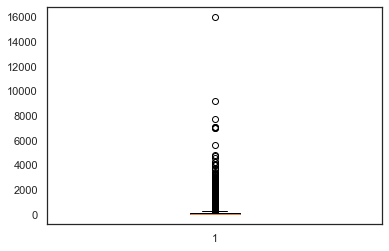

In [26]:
plt.boxplot(rfm_df.Monetary)

In [27]:
rfm_df.Monetary.mean()

141.4203293927453

In [28]:
rfm_df.Monetary.std()

386.06278069454373

In [29]:
upper_limit=rfm_df.Monetary.mean()+3*rfm_df.Monetary.std()
upper_limit

1299.6086714763765

In [30]:
lower_limit=rfm_df.Monetary.mean()-3*rfm_df.Monetary.std()
lower_limit

-1016.7680126908858

In [31]:
rfm_df=rfm_df[(rfm_df.Monetary<upper_limit)&(rfm_df.Monetary>lower_limit)]

{'whiskers': [<matplotlib.lines.Line2D at 0x171f77087c0>,
 'caps': [<matplotlib.lines.Line2D at 0x171f7708d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x171f77084c0>],
 'medians': [<matplotlib.lines.Line2D at 0x171f7716340>],
 'fliers': [<matplotlib.lines.Line2D at 0x171f7716610>],
 'means': []}

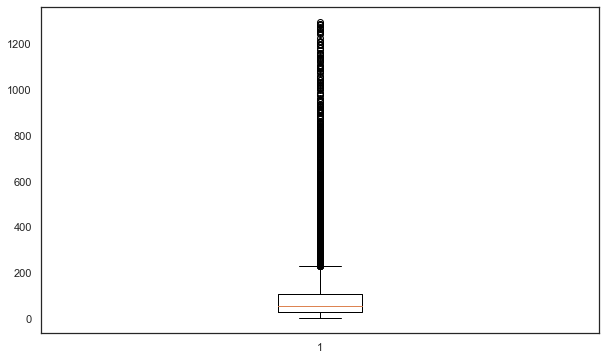

In [32]:
plt.figure(figsize=(10, 6))
plt.boxplot(rfm_df.Monetary)

In [33]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [34]:
rfm1=rfm_df[['Recency','Frequency','Monetary']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[-0.789141  , -0.28505126, -0.42991698],
       [ 0.96604399, -0.28505126, -0.38705507],
       [-0.75218973, -0.28505126,  0.2926123 ],
       ...,
       [ 0.51339102, -0.28505126, -0.42991698],
       [ 1.70506924, -0.28505126, -0.05028295],
       [ 0.71662296, -0.28505126, -0.26459248]])

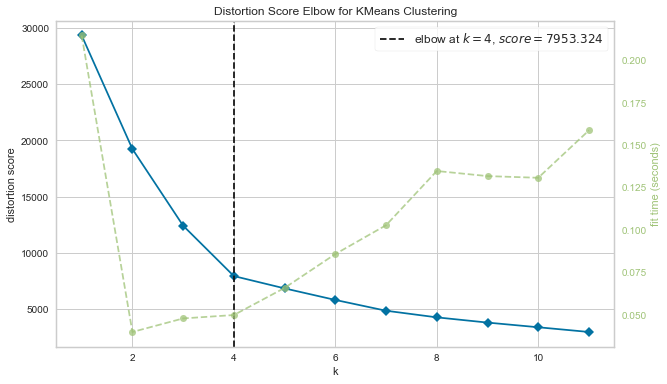

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [35]:
from yellowbrick.cluster import InterclusterDistance, KElbowVisualizer, SilhouetteVisualizer

plt.figure(figsize=(10, 6))

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show() 

[1 2 1 ... 2 2 2]
 Our cluster centers are as follows
[[ 0.86023388 -0.28505126 -0.21167935]
 [-0.15864462  3.19161288  0.69759132]
 [ 0.03808059  0.19911224  3.75156967]
 [-0.90214813 -0.28505126 -0.25009405]]


,Recency,Frequency,Monetary
cluster_pred,,,
0,4480,4480,4480
1,747,747,747
2,391,391,391
3,4157,4157,4157


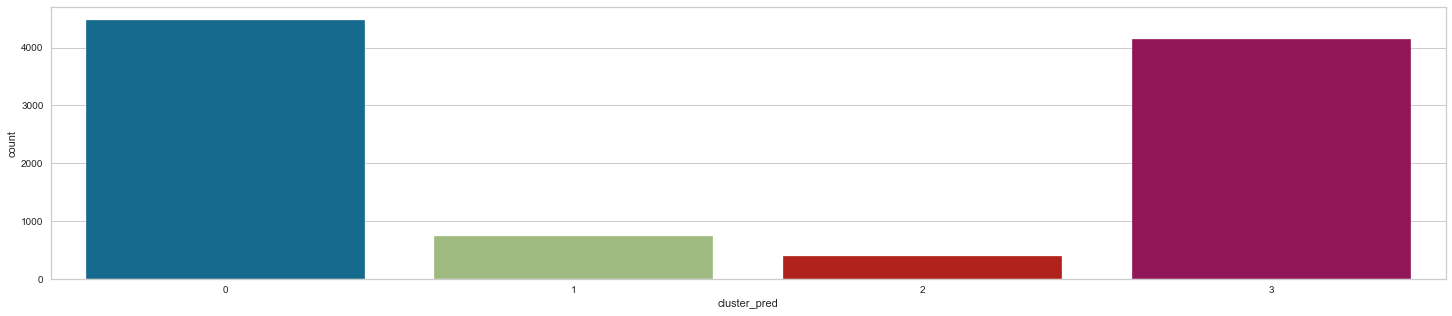

In [36]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)

print(identified_clusters)
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)

f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

In [37]:
clusters_scaled.groupby(['cluster_pred']).count()

,Recency,Frequency,Monetary
cluster_pred,,,
0,4480,4480,4480
1,747,747,747
2,391,391,391
3,4157,4157,4157


In [38]:
df_count=clusters_scaled.groupby(['cluster_pred']).count()

In [39]:
df_count=pd.DataFrame(df_count)
df_count=df_count.loc[:,'Recency'].rename_axis('k_cluster').reset_index()
df_count.rename(columns = {'Recency':'count'}, inplace = True)

df_count

,k_cluster,count
0,0,4480
1,1,747
2,2,391
3,3,4157


In [40]:
df_mean=clusters_scaled.groupby(['cluster_pred']).mean()

In [41]:
df_mean=pd.DataFrame(df_mean)
df_mean=df_mean.rename_axis('k_cluster').reset_index()

df_mean

,k_cluster,Recency,Frequency,Monetary
0,0,273.545982,1.000000,75.641518
1,1,163.251673,2.175368,224.139224
2,2,184.547315,1.163683,722.900256
3,3,82.766899,1.000000,69.367813


In [42]:
df_cluster = df_count.merge(df_mean, on='k_cluster')

df_cluster

,k_cluster,count,Recency,Frequency,Monetary
0,0,4480,273.545982,1.000000,75.641518
1,1,747,163.251673,2.175368,224.139224
2,2,391,184.547315,1.163683,722.900256
3,3,4157,82.766899,1.000000,69.367813


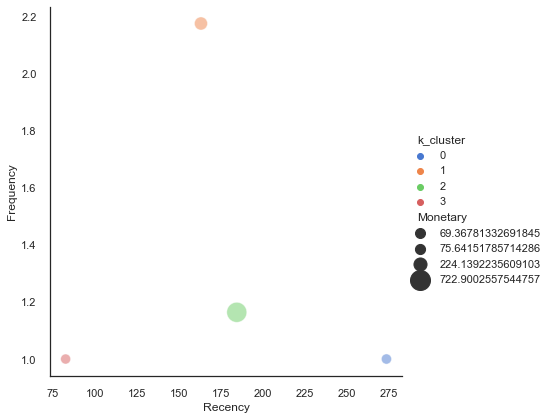

In [43]:
sns.set_theme(style="white")
sns.relplot(x="Recency", y="Frequency",hue="k_cluster", size="Monetary", sizes=(100, 400), alpha=.5, palette="muted",
            height=6, data=df_cluster)

In [44]:
clusters_scaled.head()

,Recency,Frequency,Monetary,cluster_pred
0,95,1,40.0,3
1,285,1,47.0,0
2,99,1,158.0,3
3,223,1,46.0,0
4,22,1,44.0,3


C:\Users\saeid\AppData\Local\Temp\ipykernel_28116\2613419932.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax= Axes3D(fig,


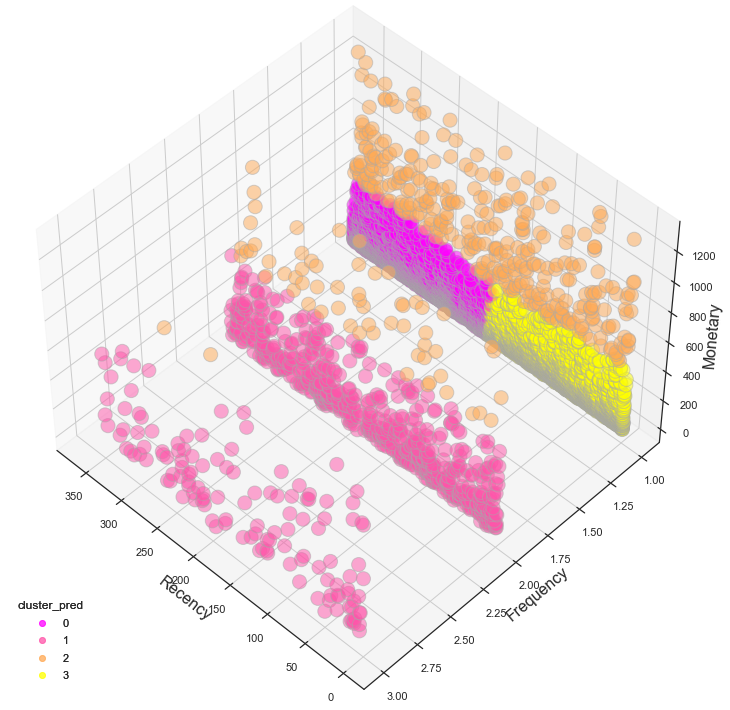

In [45]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(10,10))
plt.clf()
ax= Axes3D(fig,
           rect=[0,0,.95,1],
           elev=48,
           azim=134)
plt.cla()
sc=ax.scatter(clusters_scaled['Recency'],clusters_scaled['Frequency'],clusters_scaled['Monetary'],c=clusters_scaled['cluster_pred'],
           s=200,cmap='spring',
           alpha=0.5,
           edgecolor='darkgrey')
ax.set_xlabel('Recency',fontsize=16)
ax.set_ylabel('Frequency',fontsize=16)
ax.set_zlabel('Monetary',fontsize=16)



legend1 = ax.legend(*sc.legend_elements(),
                    loc="lower left", title="cluster_pred")
ax.add_artist(legend1)

plt.show()

In [46]:
df_cluster.to_csv('df_cluster.csv')

In [47]:
df_cluster

,k_cluster,count,Recency,Frequency,Monetary
0,0,4480,273.545982,1.000000,75.641518
1,1,747,163.251673,2.175368,224.139224
2,2,391,184.547315,1.163683,722.900256
3,3,4157,82.766899,1.000000,69.367813
